In [1]:
using Gurobi, JuMP   #JuMP是一个优化库(可以在里面插入优化的库，比如Gurobi) Import everything 
using DataFrames, GLM
using Plots
using Distributions
using Random
using LinearAlgebra
using DelimitedFiles

┌ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]
└ @ Base loading.jl:1342
┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1342


In [2]:
#rand-均匀分布； randn-正态分布
#Function for simulating data
function Data(n,m,a,b,c,r,s,form="newsvendor",seed=1)
	Random.seed!(seed)   #Random: Support for generating random numbers.   Random.rand!-Function是的，(seed)可以将随机数固定
	#Drawing random decision data
	x = rand(n)  #x是[0,1]之间的随机数，所以我们产生的data points是随机的
	#Drawing random outcome data
	y,y_min,y_max = Outcome(x,a,b,c,r,s,form)
	#Setting all possible values for decisions
    d = collect(0.1:1/m:0.9)
	return x,y,y_min,y_max,d
end

#Function for simulating outcome. 拟合各种函数结果
function Outcome(x,a,b,c,r,s,form="flat")
	n = length(x)
    y = zeros(n)
    #Simulating the random outcome for each random decision
    for i = 1:n
        if form == "flat"
            y[i] = a + s*randn()[1]
        elseif form == "flat-double"
            y[i] = a + s*randn()[1]
            if 0.5 <= x[i] <= 0.75
                y[i] = r*a + s*randn()[1]   #这里有随机项，所以对于相同的x值，y值也有很小的差别
            end
        elseif form == "linear"
            y[i] = a + b*x[i] + s*randn()[1]
        elseif form == "linear-double"
            y[i] = a + b*x[i] + s*randn()[1]
            if 0.5 <= x[i]
                y[i] = r*a + a*(1-r)*x[i] + s*randn()[1]
            end
        elseif form == "quadratic"
            y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]
        elseif form == "quadratic-double"
            y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]   #此处需要数字而不是数组，故需要将randn() 转化为randn()[1]
            if 0.5 <= x[i]
                y[i] = r*a + (3*a*(1-r)+2*b+c)*x[i] + (-2*a*(1-r)-2*b-c)*x[i]^2 + s*randn()[1]    #r具体是多少？如何使得函数在边界点处相等？可以用公式计算出r的表达式
            end
        elseif form == "newsvendor"
        	demand = a + s*randn()[1]
        	y[i] = -(c*x[i] + r*b*max(demand-x[i],0) + b*max(x[i]-demand,0))
        elseif form == "supplychain-normal"
        	y[i] = x[i] * (quantile(Normal(c,r),(a-x[i])/(a+b))) + s*randn()[1]
        elseif form == "supplychain-pareto"
        	y[i] = x[i] * (quantile(Pareto(c,r),(a-x[i])/(a+b))) + s*randn()[1]
        end		       
    end
    #Scaling the outcome to unit scale
    y_min = minimum(y)
    y_max = maximum(y)
    y = (y - ones(n)*y_min)./(ones(n)*(y_max-y_min))   #将y归一化
	return y,y_min,y_max
end


Outcome (generic function with 2 methods)

In [3]:
#Function for computing result  
function Result(y_min,y_max,x,a,b,c,r,form="newsvendor")
	#Computing the expected outcome for given decision
    if form == "flat"
        y = a
    elseif form == "flat-double"
        y = a
        if 0.5 <= x <= 0.75
            y = r*a               ### What is the value of r??????
        end
    elseif form == "linear"
        y = a + b*x
    elseif form == "linear-double"
        y = a + b*x
        if 0.5 <= x
            y = r*a + a*(1-r)*x
        end
    elseif form == "quadratic"
        y = a + b*x + c*x^2
    elseif form == "quadratic-double"
        y = a + b*x + c*x^2
        if 0.5 <= x
            y = r*a + (3*a*(1-r)+2*b+c)*x + (-2*a*(1-r)-2*b-c)*x^2
        end
    elseif form == "newsvendor"
    	demand = a
    	y = -(c*x + r*b*max(demand-x,0) + b*max(x-demand,0))
    elseif form == "supplychain-normal"
        y = x * (quantile(Normal(c,r),(a-x)/(a+b)))
    elseif form == "supplychain-pareto"
        y = x * (quantile(Pareto(c,r),(a-x)/(a+b)))
    end
    #Scaling the outcome to unit scale
    y = (y-y_min)/(y_max-y_min)
	return y
end

Result (generic function with 2 methods)

In [4]:
#Function for jointly estimating and optimizing
function EWO(x,y,d,kappa,lambda,M,showoutput=false)
    n = length(x)
    m = length(d)
    #Defining optimization model
	model = Model()
	set_optimizer(model, Gurobi.Optimizer)      #调用Gurobi里面的optimizer? Yep
	set_optimizer_attributes(model, "OutputFlag" => 0)   #??????  This arrow means equal to zero
    #Defining variables
    @variable(model, a)     ### 定义变量语法（general way）
    @variable(model, b)
    @variable(model, u[1:n], Bin)   #u[1:n]都是binary variable
    @variable(model, v[1:n], Bin)
    @variable(model, w[1:n], Bin)
    @variable(model, z[1:m], Bin)
    @variable(model, s[1:m] >= 0)
    @variable(model, t[1:n] >= 0)
	#Defining objective
    @objective(model, Max, sum(s[j] for j=1:m) - lambda * sum(t[i] for i=1:n))
    #Defining constraints
    @constraints(model, begin
        decision, sum(z[j] for j=1:m) == 1   #decision here is the name of the constraint
        revenue_passive[j=1:m], s[j] <= a+b*d[j]
        revenue_active[j=1:m], s[j] <= M*z[j]
        data[i=1:n], u[i] >= v[i] + w[i] - 1
        data_upper[i=1:n], x[i] - sum(d[j]*z[j] for j=1:m) >= kappa - M*v[i]   ### Meaning of this constraints? It's a linear programming problem, but the equivalents are hard to write
        data_lower[i=1:n], sum(d[j]*z[j] for j=1:m) - x[i] >= kappa - M*w[i]
        estimation_upper[i=1:n], t[i] >= y[i]-a-b*x[i]-M*(1-u[i])
        estimation_lower[i=1:n], t[i] >= -y[i]+a+b*x[i]-M*(1-u[i])
    end)
    #Optimizing model
    optimize!(model)
    obj_val = objective_value(model)
    time_val = solve_time(model)
    a_val = value.(a)
    b_val = value.(b)
    z_val = value.(z)
    return obj_val,time_val,a_val,b_val,z_val
end

EWO (generic function with 2 methods)

In [5]:
#Selecting setup
#setup = ["flat-double",100,0,0,4,1,0.05,1]
#setup = ["linear-double",100,100,0,0.75,1,0.05,1]
#setup = ["quadratic-double",100,100,-100,0.5,1,0.05,0.1]
setup = ["newsvendor",0.5,4,1,0.75,0.1,0.05,0.1]
#setup = ["supplychain-normal",1,1,4,3,0.1,0.05,0.1]
#setup = ["supplychain-pareto",1,1.5,0.25,1,0.1,0.05,0.1]

#Setting parameters    
form_data = setup[1]
alpha = setup[2]
beta = setup[3]
gamma = setup[4]
rho = setup[5]
sigma = setup[6]   #相当于前面的s
kappa = setup[7]
lambda = setup[8]
n = 1000
m = 100
big_M = 1000
seed_numbers = 100

100

In [6]:
#Printing parameter settings
println("Parameter settings:")
println("form_data: ", form_data)
println("alpha: ", alpha)
println("beta: ", beta)
println("gamma: ", gamma)
println("rho: ", rho)
println("sigma: ", sigma)
println("kappa: ", kappa)
println("lambda: ", lambda)
println("n: ", n)
println("m: ", m)
println("seed_numbers: ", seed_numbers)

Parameter settings:
form_data: newsvendor
alpha: 0.5
beta: 4
gamma: 1
rho: 0.75
sigma: 0.1
kappa: 0.05
lambda: 0.1
n: 1000
m: 100
seed_numbers: 100


In [7]:
#Generating data
x_data,y_data,y_min_data,y_max_data,d_data = Data(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_numbers)

([0.2601250914736861, 0.19031281518127185, 0.6609109399808133, 0.06719317094984745, 0.9675998379215747, 0.6456910432314067, 0.5459681993995775, 0.5268448425879988, 0.9727545053153894, 0.8681941503861808  …  0.05396706059723866, 0.574222318679148, 0.8630835157915413, 0.9597376251011864, 0.4352254480289155, 0.7363952963887221, 0.6592224743412349, 0.4588690920708318, 0.12446084234043298, 0.5958808066096684], [0.8507377169879569, 0.9202574663912096, 0.8455789010413394, 0.72440244574044, 0.4327526584872228, 0.6714532958220307, 0.7897881523861198, 0.6940821596607343, 0.3113198138965287, 0.3400522826947355  …  0.751746233247898, 0.821509079534896, 0.2853981766070202, 0.47615573692346025, 0.970332938374733, 0.490978749153405, 0.8870550598636292, 0.9098764585836091, 0.7391743303776804, 0.7831246151696827], -3.8942412258073094, -0.36374149297074987, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19  …  0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9])

In [178]:
x_data
#Writing results table to text file
writedlm("x_data.txt",x_data)

In [179]:
y_data
#Writing results table to text file
writedlm("y_data.txt", y_data)

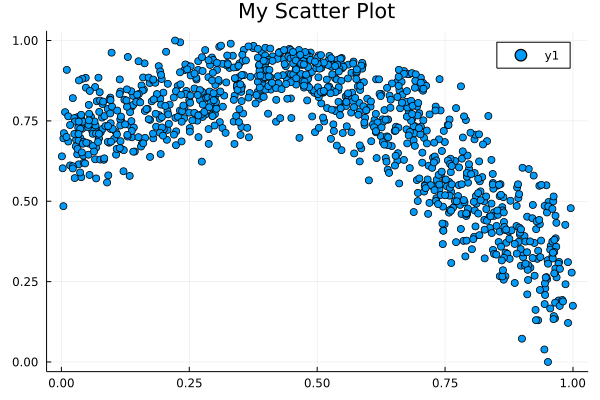

In [8]:
plot(x_data, y_data, seriestype = :scatter, title = "My Scatter Plot")

Since we cannot find the available regression tree model in Julia, I use Python instead to build the regression tree model. The x_treedata and y_treedata is stored as txt files.

In [181]:
using Parsers

In [182]:
y = Parsers.parse(Float64, "101.101")

101.101

In [183]:
# Convert the string vector to float vector
X_data = readlines("x_treedata.txt")
x_treedata = []
for i = 1:length(X_data)
    a = Parsers.parse(Float64, X_data[i])
    push!(x_treedata,a)
end

In [184]:
x_treedata

569-element Vector{Any}:
 0.2601250914736861
 0.19031281518127185
 0.6609109399808133
 0.6456910432314067
 0.5459681993995775
 0.5268448425879988
 0.17270743062211147
 0.5239900463071787
 0.5578372055383092
 0.19938059113361262
 0.3073738264292152
 0.32430299502917914
 0.6885052016067101
 ⋮
 0.42776055003159863
 0.28896394956556026
 0.4745227187995431
 0.19852093892006195
 0.3954750447262434
 0.3954600643649735
 0.47398368621021314
 0.574222318679148
 0.4352254480289155
 0.6592224743412349
 0.4588690920708318
 0.5958808066096684

In [185]:
# Convert the string vector to float vector
Y_data = readlines("y_treedata.txt")
y_treedata = []
for i = 1:length(Y_data)
    b = Parsers.parse(Float64, Y_data[i])
    push!(y_treedata,b)
end

In [186]:
y_treedata

569-element Vector{Any}:
 0.8507377169879569
 0.9202574663912096
 0.8455789010413394
 0.6714532958220307
 0.7897881523861198
 0.6940821596607343
 0.8678340292757694
 0.9519940777519057
 0.7330962270880816
 0.8378573179915522
 0.8720822964083893
 0.9300645618176062
 0.6894092212046096
 ⋮
 0.7584747781536116
 0.79219757059966
 0.8596349334478744
 0.7040638116344872
 0.8245634797111566
 0.9371230866895183
 0.9256463304892373
 0.821509079534896
 0.970332938374733
 0.8870550598636292
 0.9098764585836091
 0.7831246151696827

# Use Linear Model to Find Optimal y_value

In [134]:
#Generating data
#seed_number = 1
#x_data,y_data,y_min_data,y_max_data,d_data = Data(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_number)
com_data = hcat(x_treedata,y_treedata)
df = DataFrame(x_data = com_data[:,1],y_data = com_data[:,2])   # convert the data to DataFrame format
# Train test split
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(df,.8)   # 80% of data points belong to the training set while 20% of them belong to the test set
#Train the model
lin_mol = @formula(y_data ~ x_data)
linearRegressor = lm(lin_mol, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_data ~ 1 + x_data

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.886612   0.0128043  69.24    <1e-99   0.861448   0.911776
x_data       -0.134021   0.0270486  -4.95    <1e-05  -0.187179  -0.0808636
──────────────────────────────────────────────────────────────────────────

In [144]:
# Prediction
min_val = minimum(x_treedata)
max_y = 0.886612 - 0.134021*min_val
println("The maximal y value is: ",max_y)

The maximal y value is: 0.8669951900780801


# Using Quadratic Model to Predict Optimal y_value

In [188]:
# Obtain the square of the x_data
x_squ = x_treedata.^2   # Square every element in x_data
com_data = hcat(x_treedata,x_squ,y_treedata)
#com_data = com_data'   #The first column is x_data, the second column is y_data
df2 = DataFrame(x = com_data[:,1],x_squ = com_data[:,2],y_data = com_data[:,3])   # convert the data to DataFrame format
# Train test split
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(df2,.8)   # 80% of data points belong to the training set while 20% of them belong to the test set
#Train the model
lin_mol = @formula(y_data ~ x+x_squ)
linearRegressor = lm(lin_mol, train)

LoadError: MethodError: no method matching fit(::Type{LinearModel}, ::Matrix{Float64}, ::Matrix{Float64}, ::Nothing)
[0mClosest candidates are:
[0m  fit([91m::StatisticalModel[39m, ::Any...) at C:\Users\czq13\.julia\packages\StatsBase\DWW4r\src\statmodels.jl:178
[0m  fit(::Type{T}, [91m::FormulaTerm[39m, ::Any, ::Any...; contrasts, kwargs...) where T<:RegressionModel at C:\Users\czq13\.julia\packages\StatsModels\15rsh\src\statsmodel.jl:78
[0m  fit([91m::Type{Histogram}[39m, ::Any...; kwargs...) at C:\Users\czq13\.julia\packages\StatsBase\DWW4r\src\hist.jl:383
[0m  ...

In [150]:
df2

,x,x_squ,y_data
,Any,Any,Any
1,0.260125,0.0676651,0.850738
2,0.190313,0.036219,0.920257
3,0.660911,0.436803,0.845579
4,0.645691,0.416917,0.671453
5,0.545968,0.298081,0.789788
6,0.526845,0.277565,0.694082
7,0.172707,0.0298279,0.867834
8,0.52399,0.274566,0.951994
9,0.557837,0.311182,0.733096


# Using Our Model to Predict Optimal y_value

In [198]:
#Solving Estimate-While-Optimize model
min_val = minimum(x_treedata)
max_val = maximum(x_treedata)
d_data = collect(min_val:1/m:max_val)
solution_EWO = EWO(x_treedata,y_treedata,d_data,kappa,lambda,big_M)
y_min_data = minimum(y_treedata)
y_max_data = maximum(y_treedata)
println(y_min_data)
println(y_max_data)
#Saving solution and plotting parameters for Estimate-While-Optimize model
a_EWO = solution_EWO[3]
b_EWO = solution_EWO[4]
z_EWO = solution_EWO[5]
x_EWO = dot(d_data,z_EWO)
#y_EWO = Result(y_min_data,y_max_data,x_EWO,alpha,beta,gamma,rho,form_data)
demand = a_EWO
y = -(gamma*x_EWO + rho*b_EWO*max(demand-x_EWO,0) + b_EWO*max(x_EWO-demand,0))
#Scaling the result
y_adj = (y - y_min_data)/(y_max_data - y_min_data)
println("The optimal y value is: ",y_adj)

Academic license - for non-commercial use only - expires 2022-08-28
0.4663550261225474
1.0
The optimal y value is: 0.9303741407389791


In [3]:
import Pkg
Pkg.add("DecisionTree")
Pkg.add("RDatasets")

    Updating registry at `C:\Users\czq13\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
   Installed HarfBuzz_jll ── v2.8.1+1
   Installed Glib_jll ────── v2.68.3+2
   Installed Ogg_jll ─────── v1.3.5+1
   Installed Libtiff_jll ─── v4.3.0+1
   Installed Cairo_jll ───── v1.16.1+1
   Installed libvorbis_jll ─ v1.3.7+1
   Installed Libffi_jll ──── v3.2.2+1
   Installed DecisionTree ── v0.10.11
   Installed LERC_jll ────── v3.0.0+1
    Updating `C:\Users\czq13\.julia\environments\v1.6\Project.toml`
  [7806a523] + DecisionTree v0.10.11
    Updating `C:\Users\czq13\.julia\environments\v1.6\Manifest.toml`
  [7806a523] + DecisionTree v0.10.11
  [83423d85] ↑ Cairo_jll v1.16.1+0 ⇒ v1.16.1+1
  [7746bdde] ↑ Glib_jll v2.68.3+0 ⇒ v2.68.3+2
  [2e76f6c2] ↑ HarfBuzz_jll v2.8.1+0 ⇒ v2.8.1+1
  [88015f11] + LERC_jll v3.0.0+1
  [e9f186c6] ↑ Libffi_jll v3.2.2+0 ⇒ v3.2.2+1
  [89763e89] ↑ Libtiff_jll v4.3.0+0 ⇒ v4.3.0+1
  [e74

In [1]:
using RDatasets: dataset
using DecisionTree

In [7]:
using MLBase
using DecisionTree
using RDatasets
using Distributions
 
features, labels = load_data("iris")
features = float.(features)
labels   = string.(labels)
 
# 训练并得到决策树分类器
model = build_tree(labels, features)
#  修剪树：合并纯度大于等于90%的叶子（默认值：100%）
model = prune_tree(model, 0.9)
# 打印树, 深度为5（可选）
print_tree(model, 5)
 
# 应用所学模型
apply_tree(model, [5.9,3.0,5.1,1.9])
 
# 推测所有节点
preds = apply_tree(model, features)
 
# 生成混淆矩阵，以及准确度和kappa分数
confusion_matrix(labels, preds)
 
# 得到每个标签的概率
apply_tree_proba(model, [5.9,3.0,5.1,1.9], ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
 
# 对修剪过的树进行三次交叉验证
n_folds=3
accuracy = nfoldCV_tree(labels, features, n_folds)
 
####决策树算法的停止条件，就是一组分类参数和各自的默认值
# pruning_purity: 修剪纯度：用于修剪后的纯度阈值（默认值：1.0，不修剪）
# max_depth: 决策树的最大深度（默认值：-1，无最大值）
# min_samples_leaf: 每个叶子节点需要的最小采样数（默认值：1）
# min_samples_split: 拆分所需的最小采样数（默认值：2）
# min_purity_increase: 分割所需的最小纯度（默认值：0.0）
# n_subfeatures: 要随机选择的特征数（默认值：0，全部保留）
 
n_subfeatures=0;
max_depth=-1;
min_samples_leaf=1;
min_samples_split=2
min_purity_increase=0.0;
pruning_purity = 1.0
 
model    =   build_tree(labels, features,
                        n_subfeatures,
                        max_depth,
                        min_samples_leaf,
                        min_samples_split,
                        min_purity_increase)
 
accuracy = nfoldCV_tree(labels, features,
                        n_folds,
                        pruning_purity,
                        max_depth,
                        min_samples_leaf,
                        min_samples_split,
                        min_purity_increase)
 
print_tree(model, 5)


Feature 3, Threshold 2.45
L-> Iris-setosa : 50/50
R-> Feature 4, Threshold 1.75
    L-> Feature 3, Threshold 4.95
        L-> Iris-versicolor : 47/48
        R-> Feature 4, Threshold 1.55
            L-> Iris-virginica : 3/3
            R-> Feature 1, Threshold 6.95
                L-> Iris-versicolor : 2/2
                R-> Iris-virginica : 1/1
    R-> Feature 3, Threshold 4.85
        L-> Feature 2, Threshold 3.1
            L-> Iris-virginica : 2/2
            R-> Iris-versicolor : 1/1
        R-> Iris-virginica : 43/43

Fold 1

3×3 Matrix{Int64}:
 19   0   0
  0  13   2
  0   3  13


Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

3×3 Matrix{Int64}:
 14   0   0
  0  13   4
  0   2  17

3×3 Matrix{Int64}:
 17   0   0
  0  17   1
  0   2  13


Matrix:   
Accuracy: 0.9
Kappa:    0.8493068113321279

Fold 2
Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
Matrix:   
Accuracy: 0.88
Kappa:    0.8181818181818183

Fold 3
Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
Matrix:   
Accuracy: 0.94
Kappa:    0.9095840867992766

Mean Accuracy: 0.9066666666666666


3×3 Matrix{Int64}:
 13   0   0
  0  18   1
  0   0  18

3×3 Matrix{Int64}:
 20   0   0
  0  15   0
  0   4  11

3×3 Matrix{Int64}:
 17   0   0
  0  16   0
  0   2  15


Fold 1
Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
Matrix:   
Accuracy: 0.98
Kappa:    0.9696417729204614

Fold 2
Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
Matrix:   
Accuracy: 0.92
Kappa:    0.878787878787879

Fold 3
Classes:  ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
Matrix:   
Accuracy: 0.96
Kappa:    0.9400479616306954

Mean Accuracy: 0.9533333333333333
Feature 4, Threshold 0.8
L-> Iris-setosa : 50/50
R-> Feature 4, Threshold 1.75
    L-> Feature 3, Threshold 4.95
        L-> Feature 4, Threshold 1.65
            L-> Iris-versicolor : 47/47
            R-> Iris-virginica : 1/1
        R-> Feature 4, Threshold 1.55
            L-> Iris-virginica : 3/3
            R-> Feature 1, Threshold 6.95
                L-> Iris-versicolor : 2/2
                R-> Iris-virginica : 1/1
    R-> Feature 3, Threshold 4.85
        L-> Feature 2, Threshold 3.1
            L-> Iris-virginica : 2/2
            R-> Iris-versicolor : 1/1
        R-> Ir

In [9]:
features, labels = load_data("iris")
println(features)
println(labels)

Any[5.1 3.5 1.4 0.2; 4.9 3.0 1.4 0.2; 4.7 3.2 1.3 0.2; 4.6 3.1 1.5 0.2; 5.0 3.6 1.4 0.2; 5.4 3.9 1.7 0.4; 4.6 3.4 1.4 0.3; 5.0 3.4 1.5 0.2; 4.4 2.9 1.4 0.2; 4.9 3.1 1.5 0.1; 5.4 3.7 1.5 0.2; 4.8 3.4 1.6 0.2; 4.8 3.0 1.4 0.1; 4.3 3.0 1.1 0.1; 5.8 4.0 1.2 0.2; 5.7 4.4 1.5 0.4; 5.4 3.9 1.3 0.4; 5.1 3.5 1.4 0.3; 5.7 3.8 1.7 0.3; 5.1 3.8 1.5 0.3; 5.4 3.4 1.7 0.2; 5.1 3.7 1.5 0.4; 4.6 3.6 1.0 0.2; 5.1 3.3 1.7 0.5; 4.8 3.4 1.9 0.2; 5.0 3.0 1.6 0.2; 5.0 3.4 1.6 0.4; 5.2 3.5 1.5 0.2; 5.2 3.4 1.4 0.2; 4.7 3.2 1.6 0.2; 4.8 3.1 1.6 0.2; 5.4 3.4 1.5 0.4; 5.2 4.1 1.5 0.1; 5.5 4.2 1.4 0.2; 4.9 3.1 1.5 0.1; 5.0 3.2 1.2 0.2; 5.5 3.5 1.3 0.2; 4.9 3.1 1.5 0.1; 4.4 3.0 1.3 0.2; 5.1 3.4 1.5 0.2; 5.0 3.5 1.3 0.3; 4.5 2.3 1.3 0.3; 4.4 3.2 1.3 0.2; 5.0 3.5 1.6 0.6; 5.1 3.8 1.9 0.4; 4.8 3.0 1.4 0.3; 5.1 3.8 1.6 0.2; 4.6 3.2 1.4 0.2; 5.3 3.7 1.5 0.2; 5.0 3.3 1.4 0.2; 7.0 3.2 4.7 1.4; 6.4 3.2 4.5 1.5; 6.9 3.1 4.9 1.5; 5.5 2.3 4.0 1.3; 6.5 2.8 4.6 1.5; 5.7 2.8 4.5 1.3; 6.3 3.3 4.7 1.6; 4.9 2.4 3.3 1.0; 6.6 2.9 4.

In [8]:
print_tree(model, 5)

Feature 4, Threshold 0.8
L-> Iris-setosa : 50/50
R-> Feature 4, Threshold 1.75
    L-> Feature 3, Threshold 4.95
        L-> Feature 4, Threshold 1.65
            L-> Iris-versicolor : 47/47
            R-> Iris-virginica : 1/1
        R-> Feature 4, Threshold 1.55
            L-> Iris-virginica : 3/3
            R-> Feature 1, Threshold 6.95
                L-> Iris-versicolor : 2/2
                R-> Iris-virginica : 1/1
    R-> Feature 3, Threshold 4.85
        L-> Feature 2, Threshold 3.1
            L-> Iris-virginica : 2/2
            R-> Iris-versicolor : 1/1
        R-> Iris-virginica : 43/43


In [12]:
#相当于剪枝，对前3层决策树进行剪枝
print_tree(model,5)

Feature 4, Threshold 0.8
L-> Iris-setosa : 50/50
R-> Feature 4, Threshold 1.75
    L-> Feature 3, Threshold 4.95
        L-> Feature 4, Threshold 1.65
            L-> Iris-versicolor : 47/47
            R-> Iris-virginica : 1/1
        R-> Feature 4, Threshold 1.55
            L-> Iris-virginica : 3/3
            R-> Feature 1, Threshold 6.95
                L-> Iris-versicolor : 2/2
                R-> Iris-virginica : 1/1
    R-> Feature 3, Threshold 4.85
        L-> Feature 2, Threshold 3.1
            L-> Iris-virginica : 2/2
            R-> Iris-versicolor : 1/1
        R-> Iris-virginica : 43/43


In [13]:
# 用训练好的模型进行预测
apply_tree(model,[5.9,3.0,5.1,1.9])

"Iris-virginica"